In [27]:
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pybtex.database.input import bibtex

# Counting
import string
import nltk
from pattern.text.en import singularize, pluralize, lemma
from collections import Counter

In [2]:
# Open a bibtex file
parser = bibtex.Parser()
bibdata = parser.parse_file("imwut.bib")

# Loop through the individual references
df = None
for bib_id in bibdata.entries:
    b = bibdata.entries[bib_id].fields
    p = bibdata.entries[bib_id].persons
    
    if df is None:
        df = pd.DataFrame(columns=list(b.keys()) + ["author"])
    
    entry = dict(b)
    b["author"] = ", " .join([" ".join(name.first_names + name.last_names) for name in p["author"]])
    df = df.append(dict(b), ignore_index=True)

df.head()

,title,year,month,journal,publisher,address,volume,number,doi,url,issue_date,abstract,articleno,numpages,keywords,author
0,Leveraging Polarization of WiFi Signals to Sim...,2020,jun,Proc. ACM Interact. Mob. Wearable Ubiquitous T...,Association for Computing Machinery,"New York, NY, USA",4,2,10.1145/3397317,https://doi.org/10.1145/3397317,June 2020,"This paper presents WiPolar, an approach that ...",45,24,"WiFi, Polarimetery, CSI","Raghav Venkatnarayan, Muhammad Shahzad, Sangki..."
1,Relacks: Reliable Backscatter Communication in...,2020,jun,Proc. ACM Interact. Mob. Wearable Ubiquitous T...,Association for Computing Machinery,"New York, NY, USA",4,2,10.1145/3397314,https://doi.org/10.1145/3397314,June 2020,"The increasing number of embedded, plugged-in ...",48,24,"Internet of Things, Diversity, Reliability, Ba...","Mohamad Katanbaf, Vivek Jain, Joshua Smith"
2,SenCAPTCHA: A Mobile-First CAPTCHA Using Orien...,2020,jun,Proc. ACM Interact. Mob. Wearable Ubiquitous T...,Association for Computing Machinery,"New York, NY, USA",4,2,10.1145/3397312,https://doi.org/10.1145/3397312,June 2020,CAPTCHAs are used to distinguish between human...,43,26,"orientation sensor, user study, mobile, CAPTCHA","Yunhe Feng, Qing Cao, Hairong Qi, Scott Ruoti"
3,Personalized HeartSteps: A Reinforcement Learn...,2020,mar,Proc. ACM Interact. Mob. Wearable Ubiquitous T...,Association for Computing Machinery,"New York, NY, USA",4,1,10.1145/3381007,https://doi.org/10.1145/3381007,March 2020,With the recent proliferation of mobile health...,18,22,"Just-in-Time Adaptive Intervention, Reinforcem...","Peng Liao, Kristjan Greenewald, Predrag Klasnj..."
4,Calm Commute: Guided Slow Breathing for Daily ...,2020,mar,Proc. ACM Interact. Mob. Wearable Ubiquitous T...,Association for Computing Machinery,"New York, NY, USA",4,1,10.1145/3380998,https://doi.org/10.1145/3380998,March 2020,Commutes provide an opportune time and space f...,38,19,"Commute, Deep Breathing, Slow Breathing, Stres...","Stephanie Balters, Matthew Mauriello, So Park,..."


In [3]:
# Filter out by number of pages.
df["numpages"] = df["numpages"].astype(int)
df = df.drop(df[df["numpages"] < 5].index, axis="index")

df.head()

,title,year,month,journal,publisher,address,volume,number,doi,url,issue_date,abstract,articleno,numpages,keywords,author
0,Leveraging Polarization of WiFi Signals to Sim...,2020,jun,Proc. ACM Interact. Mob. Wearable Ubiquitous T...,Association for Computing Machinery,"New York, NY, USA",4,2,10.1145/3397317,https://doi.org/10.1145/3397317,June 2020,"This paper presents WiPolar, an approach that ...",45,24,"WiFi, Polarimetery, CSI","Raghav Venkatnarayan, Muhammad Shahzad, Sangki..."
1,Relacks: Reliable Backscatter Communication in...,2020,jun,Proc. ACM Interact. Mob. Wearable Ubiquitous T...,Association for Computing Machinery,"New York, NY, USA",4,2,10.1145/3397314,https://doi.org/10.1145/3397314,June 2020,"The increasing number of embedded, plugged-in ...",48,24,"Internet of Things, Diversity, Reliability, Ba...","Mohamad Katanbaf, Vivek Jain, Joshua Smith"
2,SenCAPTCHA: A Mobile-First CAPTCHA Using Orien...,2020,jun,Proc. ACM Interact. Mob. Wearable Ubiquitous T...,Association for Computing Machinery,"New York, NY, USA",4,2,10.1145/3397312,https://doi.org/10.1145/3397312,June 2020,CAPTCHAs are used to distinguish between human...,43,26,"orientation sensor, user study, mobile, CAPTCHA","Yunhe Feng, Qing Cao, Hairong Qi, Scott Ruoti"
3,Personalized HeartSteps: A Reinforcement Learn...,2020,mar,Proc. ACM Interact. Mob. Wearable Ubiquitous T...,Association for Computing Machinery,"New York, NY, USA",4,1,10.1145/3381007,https://doi.org/10.1145/3381007,March 2020,With the recent proliferation of mobile health...,18,22,"Just-in-Time Adaptive Intervention, Reinforcem...","Peng Liao, Kristjan Greenewald, Predrag Klasnj..."
4,Calm Commute: Guided Slow Breathing for Daily ...,2020,mar,Proc. ACM Interact. Mob. Wearable Ubiquitous T...,Association for Computing Machinery,"New York, NY, USA",4,1,10.1145/3380998,https://doi.org/10.1145/3380998,March 2020,Commutes provide an opportune time and space f...,38,19,"Commute, Deep Breathing, Slow Breathing, Stres...","Stephanie Balters, Matthew Mauriello, So Park,..."


['Desheng Zhang', 'Daqing Zhang', 'Yong Li', 'Jie Xiong', 'Gregory Abowd', 'Yuanchun Shi', 'Chun Yu', 'Vassilis Kostakos', 'Fan Zhang', 'Wei Wang']


<AxesSubplot:xlabel='author', ylabel='Total publications'>

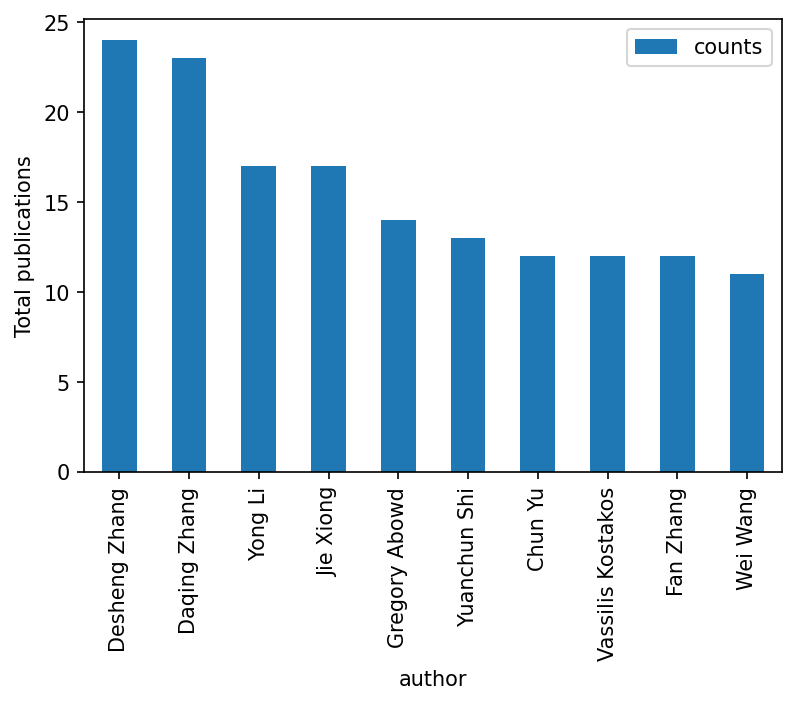

In [29]:
# Count authors in total.
names, counts = np.unique(", ".join(df.author.tolist()).split(", "), return_counts=True)
df_author_counts = pd.DataFrame(
    {
        "author": names,
        "counts": counts
    }
)
df_author_counts = df_author_counts.sort_values(by="counts", ascending=False)

# Get top authors.
top_authors = df_author_counts.head(10).author.tolist()
print(top_authors)

# Plot.
fig, ax = plt.subplots(dpi=150)
ax.set_xlabel("Author")
ax.set_ylabel("Total publications")

df_author_counts.head(10).set_index("author").plot.bar(ax=ax)

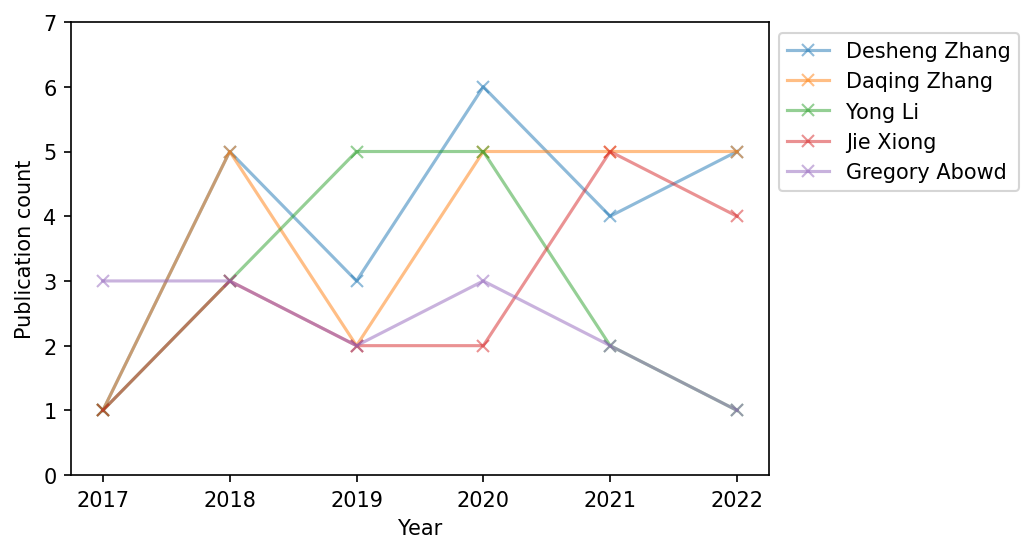

In [30]:
# Get author's publication by year. 
target_authors = top_authors[:5]

# Init plot.
fig, ax = plt.subplots(dpi=150)
ax.set_ylim([0, 7])
ax.set_xlabel("Year")
ax.set_ylabel("Publication count")

for target_author in target_authors:
    df_author = df[df.author.str.contains(target_author)]
    ax.plot(df_author.groupby("year").title.count(), 
            label=target_author, ls="-", marker="x", alpha=0.5)
ax.legend(bbox_to_anchor=(1, 1))

In [17]:
# Keywords analysis.
list_df_keyword_counts = []

for year in np.sort(df.year.unique()):
    
    # Slicing and counting.
    df_year = df[df.year == year].dropna(subset=["keywords"])
    all_year_keywords = ", ".join(df_year.keywords.tolist())
    all_year_keywords = [keyword.strip() for keyword in all_year_keywords.lower().split(",")]
    keywords, counts = np.unique(all_year_keywords, return_counts=True)

    # Make dataframe
    df_keyword_counts = pd.DataFrame(
        {
            "keyword": keywords,
            "keyword_count": counts,
            "year": year
        }
    )
    df_keyword_counts = df_keyword_counts.sort_values(by="keyword_count", ascending=False).head(5)
    
    # Appending.
    list_df_keyword_counts.append(df_keyword_counts)

# Collating.
df_keyword_counts = pd.concat(list_df_keyword_counts)
df_keyword_counts.head(10)

,keyword,keyword_count,year
226,personal informatics,3,2017
71,deep learning,3,2017
6,activity recognition,3,2017
60,crowdsourcing,3,2017
145,indoor localization,2,2017
450,mobile sensing,10,2018
178,deep learning,10,2018
414,machine learning,9,2018
15,activity recognition,8,2018
379,internet of things,7,2018


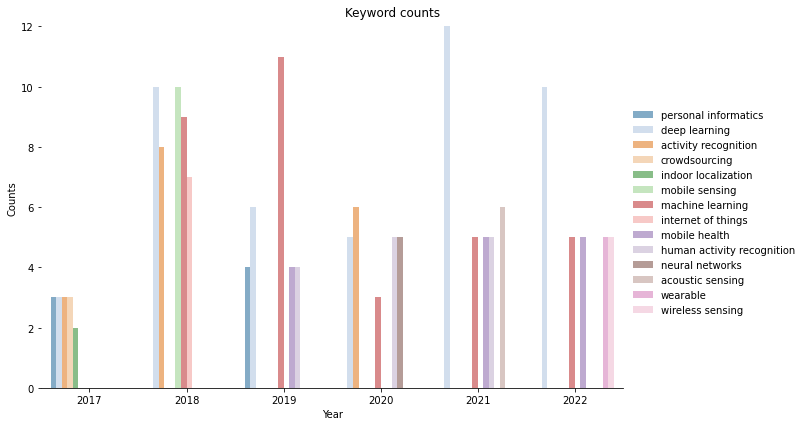

In [19]:
# Draw a nested barplot
g = sns.catplot(aspect=1.5,
    data=df_keyword_counts, kind="bar",
    x="year", y="keyword_count", hue="keyword",
    palette="tab20", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "Counts")
g.figure.suptitle("Keyword counts")
g.legend.set_title("")

In [15]:
# Title analysis.
list_df_title_counts = []

for year in np.sort(df.year.unique()):
    
    # Slicing.
    df_year = df[df.year == year].dropna(subset=["title"])

    # Preprocessing.
    combined_text = " ".join(df_year.title).lower()
    # Remove punctuation.
    combined_text.translate(str.maketrans("", "", string.punctuation))
    # Remove prepositions, conjunctions, etc. 
    tokens = nltk.word_tokenize(combined_text)
    tagged = nltk.pos_tag(tokens)
    black_list = ["%", "result",]
    white_list = ["NN", "NNS", "NNP", "NNPS"]
    filtered = list(filter(lambda x: x[1] in white_list, tagged))
    filtered = [token[0] for token in filtered]
    filtered = list(filter(lambda x: x not in black_list, filtered))
    filtered = [singularize(word) for word in filtered]

    # Counting and sorting.
    wordcount = Counter(filtered)
    ser_wordcount = pd.Series(wordcount)
    ser_wordcount = ser_wordcount.sort_values(ascending=False)
    

    # Make dataframe
    df_title_counts = pd.DataFrame(
        {
            "word": ser_wordcount.index,
            "word_count": ser_wordcount.values,
            "year": year
        }
    )
    df_title_counts = df_title_counts.sort_values(by="word_count", ascending=False).head(5)
    
    # Appending.
    list_df_title_counts.append(df_title_counts)

# Collating.
df_title_counts = pd.concat(list_df_title_counts)
df_title_counts.head(10)

,word,word_count,year
0,datum,10,2017
1,device,8,2017
2,recognition,7,2017
3,system,6,2017
4,activity,6,2017
0,datum,17,2018
1,system,16,2018
2,sensor,15,2018
3,device,14,2018
4,activity,12,2018


Text(0.5, 0.98, 'Title word frequencies')

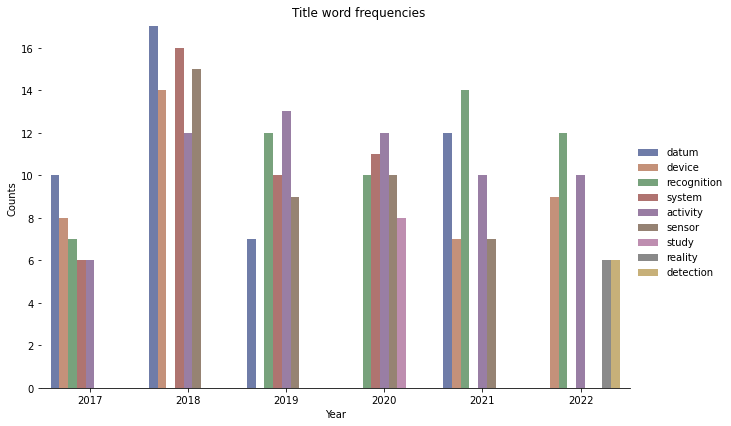

In [16]:
# Draw a nested barplot
g = sns.catplot(aspect=1.5,
    data=df_title_counts, kind="bar",
    x="year", y="word_count", hue="word",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "Counts")
g.legend.set_title("")
g.figure.suptitle("Title word frequencies")

In [13]:
# Abstract analysis.
list_df_abstract_counts = []

for year in np.sort(df.year.unique()):
    
    # Slicing.
    df_year = df[df.year == year].dropna(subset=["abstract"])

    # Preprocessing.
    combined_text = " ".join(df_year.abstract).lower()
    # Remove punctuation.
    combined_text.translate(str.maketrans("", "", string.punctuation))
    # Remove prepositions, conjunctions, etc. 
    tokens = nltk.word_tokenize(combined_text)
    tagged = nltk.pos_tag(tokens)
    black_list = ["%", "result",]
    white_list = ["NN", "NNS", "NNP", "NNPS"]
    filtered = list(filter(lambda x: x[1] in white_list, tagged))
    filtered = [token[0] for token in filtered]
    filtered = list(filter(lambda x: x not in black_list, filtered))
    filtered = [singularize(word) for word in filtered]

    # Counting and sorting.
    wordcount = Counter(filtered)
    ser_wordcount = pd.Series(wordcount)
    ser_wordcount = ser_wordcount.sort_values(ascending=False)
    

    # Make dataframe
    df_abstract_counts = pd.DataFrame(
        {
            "word": ser_wordcount.index,
            "word_count": ser_wordcount.values,
            "year": year
        }
    )
    df_abstract_counts = df_abstract_counts.sort_values(by="word_count", ascending=False).head(5)
    
    # Appending.
    list_df_abstract_counts.append(df_abstract_counts)

# Collating.
df_abstract_counts = pd.concat(list_df_abstract_counts)
df_abstract_counts.head(10)

,word,word_count,year
0,datum,95,2017
1,user,82,2017
2,device,70,2017
3,study,69,2017
4,system,69,2017
0,system,297,2018
2,datum,287,2018
1,user,287,2018
3,device,198,2018
4,approach,141,2018


Text(0.5, 0.98, 'Abstract word frequencies')

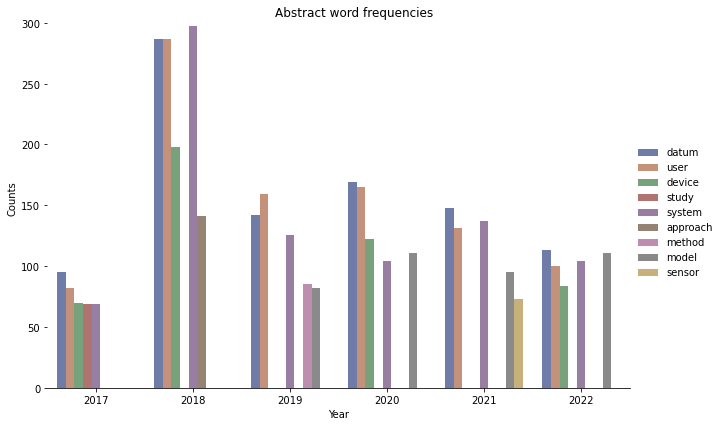

In [14]:
# Draw a nested barplot
g = sns.catplot(aspect=1.5,
    data=df_abstract_counts, kind="bar",
    x="year", y="word_count", hue="word",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "Counts")
g.legend.set_title("")
g.figure.suptitle("Abstract word frequencies")